## CSC420 Assignment 4
### Brendan Neal | 1001160236 | nealbre1

Imports and some helper functions

In [1]:
import numpy as np
from scipy import spatial
import cv2 as cv
import math
import re
import os
import tensorflow as tf

from matplotlib import pyplot as plot

# Make the plot a certain size
plot.rcParams["figure.figsize"] = [8, 6]


def display_image(img, file_name=None, save_norm=True, save_type=np.uint8):
    """
    Shows an image (max-min normalized to 0-255), and saves it if a filename is given 
    save_norm = whether to save the normalized image
    save_type = what datatype to save the image as
    """
    
    flt_img = img.astype(float)
    img_max, img_min = np.max(flt_img), np.min(flt_img)
    norm = (((flt_img - img_min) / (img_max - img_min)) * 255).astype(np.uint8)
    
    if len(img.shape) == 2:
        plot.imshow(norm, cmap='gray')  
    elif (len(img.shape) == 3):
        plot.imshow(cv.cvtColor(norm, cv.COLOR_BGR2RGB))
    plot.show()
    
    to_save = norm if save_norm else flt_img
    if file_name:
        cv.imwrite(file_name, to_save)

#### Question 2a: Depth Calculation

Formula for depth calculation:
$$z = \frac{f \times b}{d}$$
Where:

$z$ : z-depth of the pixel

$f$ : focal length of the camera(s)

$b$ : base width of the two camera

$d$ : disparity of the pixel

Code to grab calculate depth image and get camera params:

In [2]:
def depth_image(disparity_image, base_width, focal_length):
    """
    Creates a depth image using a disparity image and 
    some camera parameters (base width, focal length)
    """
    numerator = base_width * focal_length
    
    # Avoid div 0 errors
    denominator = disparity_image.astype(float)
    denominator[denominator == 0] = 1
    result = numerator / denominator
    
    # Set what should have been infinity to maximum
    result[denominator == 0] = np.max(result)
    
    return result


def get_camera_params(param_path):
    """
    Returns dictionary of camera parameter values 
    stored in the file at param_path
    """
    
    # Lines of the file are of form (param : value)
    line_regex = re.compile(r"(?P<param>(\w+)):(\s+)(?P<value>(\d+(\.\d+)?))")
    
    with open(param_path, "r") as file:
    
        # Matching the regex to the lines in the file
        matches = (line_regex.match(line) for line in file.readlines())
        
        # Organize the parameters into a dictionary for easy access
        return {
            match.group("param") : float(match.group("value"))
            for match in matches
        }

Running the above code for the first 3 images in the *test* folder:

004945


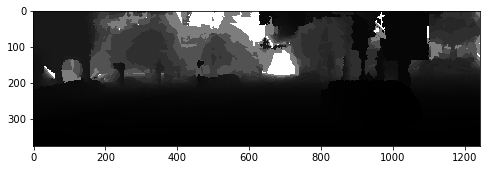

004964


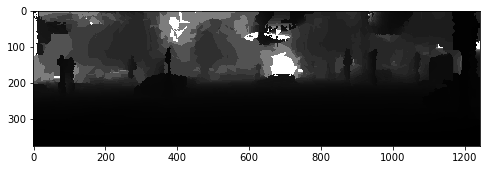

005002


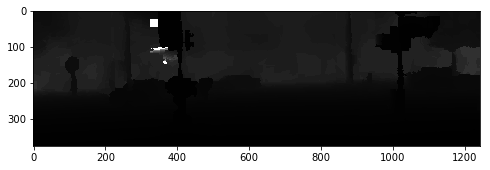

In [3]:
# Only need 3 image IDs in test
test_image_ids = [
    x.strip()
    for x in open("data/test/test.txt", "r").readlines()
]

for id_num in test_image_ids[:3]:
    camera_params = get_camera_params("data/test/calib/{}_allcalib.txt".format(id_num))
    disparity_img = cv.imread("data/test/results/{}_left_disparity.png".format(id_num))
    depth_img = depth_image(disparity_img, camera_params["baseline"], camera_params["f"])
    
    print(id_num)
    display_image(depth_img, "q2a-{}-depth.png".format(id_num), save_norm=False, save_type=np.float32)

#### Question 2b: Object Detection

Code to import and run a pre-trained tensorflow model:

Running code on images (using COCO-trained Mobile Net):

In [8]:
def load_frozen_graph(model_folder):
    """
    Adapted from:
    https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc
    """
    # Load the graph definition
    frozen_graph_path = os.path.join(model_folder, r"frozen_inference_graph.pb")
    
    with tf.gfile.GFile(frozen_graph_path, "rb") as graph_file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(graph_file.read())
        
    # Import the definition into a graph, return it
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
        
    # Return the loaded graph
    return graph

def detect_objects(graph, image, threshold):
    """
    Adapted from: 
    https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
    
    Changed to return numpy array of form:
    [[x_left, y_top, x_right, y_bottom, confidence, class]]
    
    Where each row represents a bounding box's diagonal coordinates, 
    confidence score and classification.
    """
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}

            for key in ['num_detections', 'detection_boxes', 'detection_scores', 
                        'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)

            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})
                
            ###### MY OWN CODE TO CHANGE FORMAT OF OUTPUT #######
            img_height, img_width = image.shape[:2]
            num_detections = int(output["num_detections"][0])
            
            # Return a numpy array where each row has the following form:
            #     (x_left, y_top, x_right, y_bottom, confidence, class)
            # Coordinates are NOT normalized (they are actual image coordinates)
            classes = output["detection_classes"][0][:num_detections]
            box_coords = output["detection_boxes"][0][:num_detections] * np.array([img_width, img_height, img_width, img_height])
            scores = output["detection_scores"][0][:num_detections]
            
            # Stack the above matrices horizontally
            stacked = np.hstack((box_coords.astype(int), scores, classes.astype(int)))
            
            # Only take the rows where scores are above threshold
            return stacked[scores >= threshold]

In [9]:
coco_mobile_net = load_frozen_graph("coco-mobile-net")

for img_id in test_image_ids:
    img = cv.imread("data/test/left/{}.jpg".format(img_id))
    detection = detect_objects(coco_mobile_net, img, 0.5)
    
    # Save detections in test results folder
    np.save("data/test/results/{}_detections.npy".format(img_id), detection)

ValueError: all the input arrays must have same number of dimensions